## Read Data

read data from file use pandas

In [152]:
#from google.colab import files

#uploaded = files.upload()

import pandas as pd
dataframe = pd.read_csv('motoviechle.csv', delimiter=';')

/var/folders/0q/22f144kx4dn41cw151l589xh0000gn/T/ipykernel_76855/2957372832.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  dataframe = pd.read_csv('motoviechle.csv', delimiter=';')


In [110]:
['ID', 'Date_start_contract', 'Date_last_renewal', 'Date_next_renewal',
       'Date_birth', 'Date_driving_licence', 'Distribution_channel',
       'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
       'Lapse', 'Date_lapse', 'Payment', 'Premium', 'Cost_claims_year',
       'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk',
       'Area', 'Second_driver', 'Year_matriculation', 'Power',
       'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length',
       'Weight']

['ID',
 'Date_start_contract',
 'Date_last_renewal',
 'Date_next_renewal',
 'Date_birth',
 'Date_driving_licence',
 'Distribution_channel',
 'Seniority',
 'Policies_in_force',
 'Max_policies',
 'Max_products',
 'Lapse',
 'Date_lapse',
 'Payment',
 'Premium',
 'Cost_claims_year',
 'N_claims_year',
 'N_claims_history',
 'R_Claims_history',
 'Type_risk',
 'Area',
 'Second_driver',
 'Year_matriculation',
 'Power',
 'Cylinder_capacity',
 'Value_vehicle',
 'N_doors',
 'Type_fuel',
 'Length',
 'Weight']

## Data preprocessing

In [116]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [153]:
# remove id
dataframe = dataframe.drop(columns=["ID"])

# remove rows with same values
dataframe = dataframe.drop_duplicates()#subset=['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal',
    #    'Date_birth', 'Date_driving_licence', 'Distribution_channel',
    #    'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
    #    'Lapse', 'Date_lapse', 'Payment', 'Premium', 'Cost_claims_year',
    #    'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk',
    #    'Area', 'Second_driver', 'Year_matriculation', 'Power',
    #    'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length',
    #    'Weight'])

### 0. Split the data

1. split train data and test data with 80% and 20%
2. split the train data to train data and validation data with 80% and 20%

In [118]:
# set random seed for reproducibility
# train_test_split
df_train, df_test = train_test_split(dataframe, test_size=0.2, random_state=42)
# train,validation
# df_train, data_val = train_test_split(df_train, test_size=0.1, random_state=42)

In [6]:
print(f"train shape: {df_train.shape}")
# print(f"validation shape: {data_val.shape}")
print(f"test shape: {df_test.shape}")

train shape: (84443, 29)
test shape: (21111, 29)


### 1. Date processing

use the date data to extract duration features

In [35]:
def process_date_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    date_columns = [
        "Date_start_contract",
        "Date_last_renewal",
        "Date_next_renewal",
        "Date_birth",
        "Date_driving_licence",
        "Date_lapse",
    ]

    # convert date columns to datetime
    dataframe[date_columns] = dataframe[date_columns].apply(
        pd.to_datetime, format="%d/%m/%Y"
    )

    dataframe["Age_at_contract_start"] = (
        dataframe["Date_start_contract"] - dataframe["Date_birth"]
    ).dt.days / 365.25
    dataframe["Driving_experience_at_contract_start"] = (
        dataframe["Date_start_contract"] - dataframe["Date_driving_licence"]
    ).dt.days / 365.25
    dataframe["Contract_duration"] = (
        dataframe["Date_last_renewal"] - dataframe["Date_start_contract"]
    ).dt.days
    dataframe["Days_until_next_renewal"] = (
        dataframe["Date_next_renewal"] - dataframe["Date_last_renewal"]
    ).dt.days
    dataframe["Total_contract_duration"] = (
        dataframe["Date_next_renewal"] - dataframe["Date_start_contract"]
    ).dt.days
    dataframe["Contract_terminated"] = dataframe["Date_lapse"].notnull().astype(int)

    duration_columns = [
        "Age_at_contract_start",
        "Driving_experience_at_contract_start",
        "Contract_duration",
        "Days_until_next_renewal",
        "Total_contract_duration",
    ]

    dataframe = dataframe.drop(columns=date_columns)
    dataframe[duration_columns] = StandardScaler().fit_transform(
        dataframe[duration_columns]
    )

    return dataframe

### 2. Categorical data processing

In [36]:
def process_categorical_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    muti_categorical_columns = [
        "Type_risk",
        "Type_fuel",
    ]

    # convert multi categorical columns to one hot encoding
    dataframe = pd.get_dummies(dataframe, columns=muti_categorical_columns)

    return dataframe

### 3. Numerical data processing

In [37]:
def process_numerical_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    numerical_columns = [
        "Seniority",
        "Policies_in_force",
        "Max_policies",
        "Max_products",
        "Lapse",
        "Premium",
        "Cost_claims_year",
        "N_claims_year",
        "N_claims_history",
        "R_Claims_history",
        "Area",
        "Second_driver",
        "Power",
        "Cylinder_capacity",
        "Value_vehicle",
        "N_doors",
        "Length",
        "Weight",
    ]

    dataframe[numerical_columns] = dataframe[numerical_columns].apply(
        pd.to_numeric, errors="coerce"
    )
    # fill "Length" column with mean
    dataframe["Length"] = dataframe["Length"].fillna(dataframe["Length"].mean())
    dataframe = dataframe.dropna()

    scaler = StandardScaler()
    dataframe[numerical_columns] = scaler.fit_transform(dataframe[numerical_columns])

    return dataframe

### 4. Binary

In [38]:
def process_binary_columns(dataframe: pd.DataFrame) -> pd.DataFrame:
    binary_columns = ["Distribution_channel", "Payment", "Area", "Second_driver"]
    # remove nan values
    dataframe[binary_columns] = dataframe[binary_columns].apply(
        pd.to_numeric, errors="coerce"
    )
    dataframe = dataframe.dropna()
    return dataframe

In [41]:
def process_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = process_date_columns(dataframe)
    dataframe = process_categorical_columns(dataframe)
    dataframe = process_numerical_columns(dataframe)
    dataframe = process_binary_columns(dataframe)
    return dataframe


df_train = process_data(df_train)
df_test = process_data(df_test)
# df_val = process_data(data_val)

KeyError: "None of [Index(['Date_start_contract', 'Date_last_renewal', 'Date_next_renewal',\n       'Date_birth', 'Date_driving_licence', 'Date_lapse'],\n      dtype='object')] are in the [columns]"

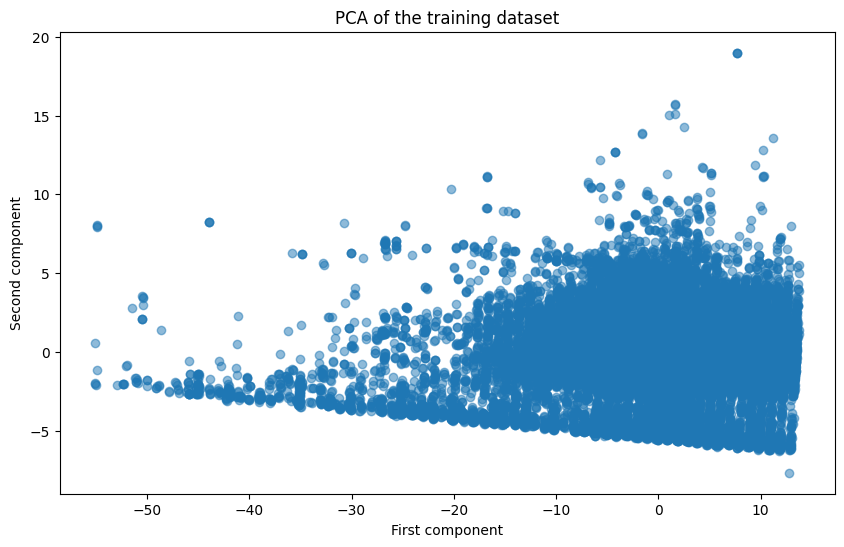

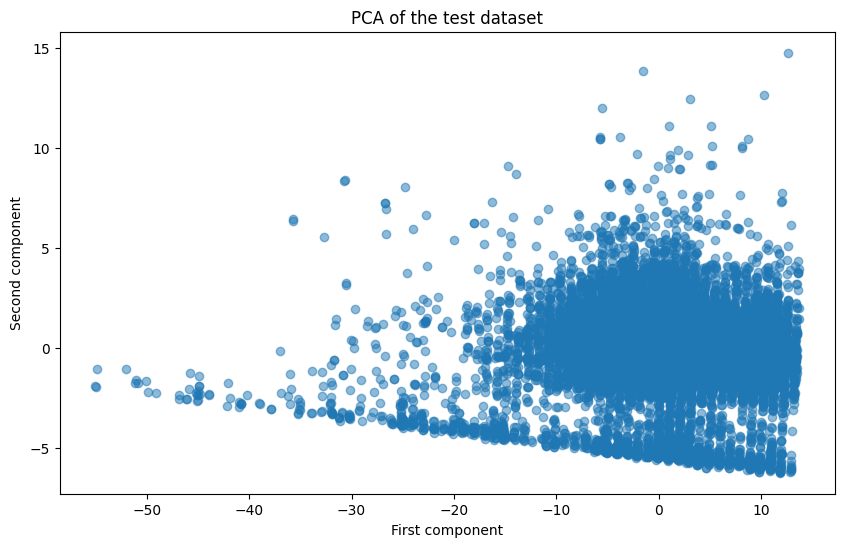

In [13]:
# Visualize the data
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


def plot_pca(dataframe: pd.DataFrame, title: str = "PCA of the dataset"):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
    plt.title(title)
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.show()


plot_pca(df_train, title="PCA of the training dataset")
plot_pca(df_test, title="PCA of the test dataset")

GAN

In [33]:
def draw_value_count_histogram(dataframe: np.ndarray, title: str):
    plt.figure(figsize=(10, 6))
    plt.hist(dataframe, alpha=0.5)
    plt.title(title)
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.show()


def draw_pca(dataframe: pd.DataFrame, labels: pd.DataFrame, title: str):
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)
    plt.figure(figsize=(10, 6))
    plt.scatter(pca_result[:, 0], pca_result[:, 1], c=labels, alpha=0.5)
    plt.title(title)
    plt.xlabel("First component")
    plt.ylabel("Second component")
    plt.show()

In [75]:
from sklearn.cluster import DBSCAN


def get_labels_dbscan(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    0: anomaly
    1: normal
    """
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)

    clf = DBSCAN(eps=0.5, min_samples=5)
    labels = clf.fit_predict(pca_result)
    labels = (labels != -1).astype(int)
    return labels

train_labels_dbscan = get_labels_dbscan(df_train)
test_labels_dbscan = get_labels_dbscan(df_test)

draw_pca(df_train, train_labels_dbscan, title="PCA of the training dataset with labels")
draw_pca(df_test, test_labels_dbscan, title="PCA of the test dataset with labels")

ValueError: could not convert string to float: '10/07/2017'

In [14]:
# draw histogram of the labels
import matplotlib.pyplot as plt

df_train["Labels"] = train_labels_dbscan
df_test["Labels"] = test_labels_dbscan

df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=42)

NameError: name 'train_labels_dbscan' is not defined

In [ ]:
data_train = df_train.drop(columns=["Labels"]).astype(np.float32).values
data_test = df_test.drop(columns=["Labels"]).astype(np.float32).values
data_val = df_val.drop(columns=["Labels"]).astype(np.float32).values

data_train = torch.tensor(data_train)
data_test = torch.tensor(data_test)
data_val = torch.tensor(data_val)

print(f"train shape: {data_train.shape}")
print(f"test shape: {data_test.shape}")
print(f"validation shape: {data_val.shape}")

train_labels = df_train["Labels"].values
test_labels = df_test["Labels"].values
val_labels = df_val["Labels"].values

train_labels = torch.tensor(train_labels).reshape(-1, 1)
test_labels = torch.tensor(test_labels).reshape(-1, 1)
val_labels = torch.tensor(val_labels).reshape(-1, 1)

print(f"train labels shape: {train_labels.shape}")
print(f"test labels shape: {test_labels.shape}")
print(f"validation labels shape: {val_labels.shape}")

In [ ]:
if torch.cuda.is_available():
    # Set device to GPU
    device = torch.device("cuda")

else:
    # Set device to CPU
    device = torch.device("cpu")

In [ ]:
class Block(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super(Block, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(in_dim, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, x):
        return self.model(x)


class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()
        self.block1 = Block(latent_dim, 256, 512)
        self.block2 = Block(512, 256, 256)
        self.block3 = Block(256, 128, 256)
        self.block4 = nn.Sequential(
            nn.Linear(256, output_dim),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.block1(x)
        x = F.relu(x)
        x = self.block2(x)
        x = F.relu(x)
        x = self.block3(x)
        x = self.block4(x)
        return x



class Discriminator(nn.Module):
    def __init__(self, input_dim):
        super(Discriminator, self).__init__()
        self.block1 = Block(input_dim, 256, 512)
        self.block2 = Block(512, 256, 256)
        self.block3 = Block(256, 128, 64)
        self.output_layer = nn.Linear(64, 1)

    def forward(self, x):
        x = self.block1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.block2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.block3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.output_layer(x)
        return x

In [ ]:
def get_dataloader(
    data,
    label,
    batch_size=512,
):
    dataset = TensorDataset(data, label)
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
    )


dataloader_train = get_dataloader(
    data_train,
    train_labels,
)
dataloader_test = get_dataloader(
    data_test,
    test_labels,
)
dataloader_val = get_dataloader(
    data_val,
    val_labels,
)

def cal_acc(output: np.ndarray, label: np.ndarray, class_id=0):
    output = output[label == class_id]
    label = label[label == class_id]
    return (output == label).sum() / len(output)

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from torch.cuda.amp import GradScaler, autocast

def train_epoch(
    generator,
    discriminator,
    latent_dim,
    optimizer_G,
    optimizer_D,
    dataloader,
    device,
    loss_function,
    scaler_D,
    scaler_G,
    n_critic,
    epoch_num,
    writer,
):
    Loss_epoch_D = 0
    Loss_epoch_G = 0
    for i, data in enumerate(dataloader):
        data, label = data
        data = data.to(device)
        label = label.to(device)
        batch_size = data.shape[0]

        # Train Discriminator
        discriminator.train()
        generator.eval()
        optimizer_D.zero_grad()
        with autocast():
            # Real data

            real_output = discriminator(data)
            real_loss = loss_function(real_output, label.float())

            # Fake data
            latent = torch.randn(batch_size, latent_dim).to(device)
            fake_data = generator(latent)
            fake_labels = torch.zeros(batch_size, 1).to(device)
            fake_output = discriminator(fake_data.detach())
            fake_loss = loss_function(fake_output, fake_labels)

            # Total loss
            discriminator_loss = real_loss + fake_loss
            Loss_epoch_D += discriminator_loss.item()

        scaler_D.scale(discriminator_loss).backward()
        scaler_D.step(optimizer_D)
        scaler_D.update()

        ########## Train Generator ##########
        if i % n_critic == 0:
            discriminator.eval()
            generator.train()
            optimizer_G.zero_grad()
            with autocast():
                # Train Generator
                latent = torch.randn(batch_size, latent_dim).to(device)
                fake_data = generator(latent)
                fake_output = discriminator(fake_data)
                real_labels = torch.ones(batch_size, 1).to(device)
                generator_loss = loss_function(fake_output, real_labels)

                Loss_epoch_G += generator_loss.item()

            scaler_G.scale(generator_loss).backward()
            scaler_G.step(optimizer_G)
            scaler_G.update()

    writer.add_scalar("Loss epoch/Discriminator", Loss_epoch_D, epoch_num)
    print(f"Epoch {epoch_num} - Discriminator Loss: {Loss_epoch_D:.4f}")

    writer.add_scalar("Loss epoch/Generator", Loss_epoch_G, epoch_num)
    print(f"Epoch {epoch_num} - Generator Loss: {Loss_epoch_G:.4f}")

In [ ]:
# f1 score
from sklearn.metrics import f1_score


def validate_epoch(
    generator, discriminator, latent_dim, dataloader, device, epoch_num, writer, best_f1
) -> float:
    """
    Param best_f1: use to save the best model
    """
    discriminator.eval()
    generator.eval()

    # Caculate ratio of real data classified as real
    for data in dataloader:
        data, label = data
        data = data.to(device)
        label = label.to(device)
        output = discriminator(data)
        output = torch.sigmoid(output)  # use sigmoid to get probability
        output = (output > 0.5).int()

    # noise data
    latent = torch.randn(data.shape[0], latent_dim).to(device)
    fake_data = generator(latent)
    fake_res = discriminator(fake_data)
    fake_res = torch.sigmoid(fake_res)
    fake_res = (fake_res > 0.5).int()

    label_fake = torch.zeros(data.shape[0], 1).to(device)

    output = torch.cat((output, fake_res), 0)
    label = torch.cat((label, label_fake), 0)

    # caculate f1 score
    f1 = f1_score(label.cpu().numpy(), output.cpu().numpy())

    # caculate anomaly acc and normal acc
    anomaly_acc = cal_acc(output.cpu().numpy(), label.cpu().numpy(), class_id=0)
    normal_acc = cal_acc(output.cpu().numpy(), label.cpu().numpy(), class_id=1)

    writer.add_scalar("f1/Validation", f1, epoch_num)
    writer.add_scalar("Anomaly acc/Validation", anomaly_acc, epoch_num)
    writer.add_scalar("Normal acc/Validation", normal_acc, epoch_num)

In [ ]:
def test_epoch(generator, discriminator, dataloader, device, epoch_num, writer):
    discriminator.eval()
    generator.eval()

    # Caculate ratio of real data classified as real

    for data in dataloader:
        data, label = data
        data = data.to(device)
        label = label.to(device)
        output = discriminator(data)
        output = torch.sigmoid(output)
        output = (output > 0.5).int()

    # caculate f1 score
    f1 = f1_score(label.cpu().numpy(), output.cpu().numpy())
    # caculate anomaly acc and normal acc
    anomaly_acc = cal_acc(output.cpu().numpy(), label.cpu().numpy(), class_id=0)
    normal_acc = cal_acc(output.cpu().numpy(), label.cpu().numpy(), class_id=1)
    writer.add_scalar("f1/Test", f1, epoch_num)
    writer.add_scalar("Anomaly acc/Test", anomaly_acc, epoch_num)
    writer.add_scalar("Normal acc/Test", normal_acc, epoch_num)
    print(f"Epoch {epoch_num} - F1 score: {f1:.4f}")


class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(logits, targets, reduction="none")
        probas = torch.sigmoid(logits)
        pt = torch.where(targets == 1, probas, 1 - probas)  # 选择概率
        focal_weight = self.alpha * (1 - pt) ** self.gamma
        loss = focal_weight * BCE_loss
        return loss.mean()

In [ ]:
import datetime

# Training parameters
epochs = 50
real_label = 1
fake_label = 0

scaler_D = GradScaler()
scaler_G = GradScaler()

# Initialize Generator and Discriminator
latent_dim = 64
latendim = data_train.shape[1]
generator = Generator(latent_dim, latendim).to(device)
discriminator = Discriminator(latendim).to(device)

# Define loss and optimizers
# loss_function = nn.BCEWithLogitsLoss()

loss_function = FocalLoss(alpha=0.25, gamma=2)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))

now = datetime.datetime.now()

time = now.strftime("%Y-%m-%d %H_%M")

writer = SummaryWriter(log_dir=f"logs/GAN-{time}", filename_suffix=f"{time}")

best_f1 = 0

n_critic = 1

for epoch in range(epochs):
    ######## training ########
    train_epoch(
        generator,
        discriminator,
        latent_dim,
        optimizer_G,
        optimizer_D,
        dataloader_train,
        device,
        loss_function,
        scaler_D,
        scaler_G,
        n_critic,
        epoch,
        writer,
    )

    ######## validation ########
    f1 = validate_epoch(
        generator,
        discriminator,
        latent_dim,
        dataloader_val,
        device,
        epoch,
        writer,
        best_f1=best_f1,
    )

    best_f1 = max(f1, best_f1)

    ######## test ########
    test_epoch(generator, discriminator, dataloader_test, device, epoch, writer)


print("GAN training completed!")

<ipython-input-71-3858e4ff7a49>:8: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_D = GradScaler()
/usr/local/lib/python3.10/dist-packages/torch/amp/grad_scaler.py:132: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(
<ipython-input-71-3858e4ff7a49>:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler_G = GradScaler()
<ipython-input-66-37045e8fe09b>:31: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():
/usr/local/lib/python3.10/dist-packages/torch/amp/autocast_mode.py:266: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(
<ipython-input-66-37045e8fe09b>:57: FutureWarning: `torch.cuda.amp.autocast(args...)` is depr

Epoch 0 - Discriminator Loss: 3.0001
Epoch 0 - Generator Loss: 54.2013


TypeError: '>' not supported between instances of 'int' and 'NoneType'

Transformer

In [14]:
import torch
import tensorflow as tf
import pandas as pd
import numpy as np
#from tensorflow.keras.layers import Layer, Dense, MultiHeadAttention, LayerNormalization, Dropout

In [15]:
import torch
import tensorflow as tf
import pandas as pd
import numpy as np
df = dataframe
df = df.reset_index()
df.shape
ls = ['Distribution_channel',
       'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
       'Lapse', 'Date_lapse', 'Payment', 'Premium', 'Cost_claims_year',
       'N_claims_year', 'N_claims_history', 'R_Claims_history', 'Type_risk',
       'Area', 'Second_driver', 'Year_matriculation', 'Power',
       'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Type_fuel', 'Length',
       'Weight']
col1 = ['Distribution_channel',
       'Seniority', 'Policies_in_force','Max_policies',
         'Max_products','N_claims_year', 'N_claims_history', 'Type_risk',
         'Second_driver', 'Power', 'N_doors',
       'Type_fuel']

In [16]:
from collections import defaultdict#run once
data_whole = []
for x in range(df.shape[0]):#df.shape[0]):
    ls0=[]
    for k in col1:
        v = df.loc[x,k]
        #if(isinstance(v,str)):
        v=str(v)
        ls0.append(v)
    data_whole.append(ls0)
data_whole = np.array(data_whole)
ustring = np.unique(data_whole.flatten())
ustring.shape
dict = {string: idx for idx, string in enumerate(ustring)}
len(dict)
print(dict.get("10225.0"))
dict_id = {v: k for k, v in dict.items()}
print(dict_id.get(110))
print(len(dict))

None
208
269


In [63]:
num_heads = 8#run once
d_model = 512
ff_dim = 2048
batch_size, seq_len, d_model = 32, 50, 512
num_classes = 512
vocab_size = len(dict)
num_layers = 3
class transformer(torch.nn.Module):
    def __init__(self,vocab_size, d_model, num_heads, ff_dim, num_layers):
        super(transformer, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, d_model)
        #self.positional_encoding = torch.nn.Parameter(torch.zeros(1, vocab_size, d_model))
        self.transf = torch.nn.Transformer(d_model, num_heads, num_layers, num_layers, ff_dim, batch_first=True)
        self.ffn = torch.nn.Linear(d_model, vocab_size) #torch.nn.Linear(ff_dim, d_model),
        # self.norm1 = torch.nn.LayerNorm(d_model)
        # self.norm2 = torch.nn.LayerNorm(d_model)
        #self.onedim = torch.nn.Linear(d_model)
        #self.softmax = torch.nn.Softmax()

    def forward(self, x):
        x = self.embedding(x) #+ self.positional_encoding[:, :x.size(1), :]
        output = self.transf(x, x)
        logits = self.ffn(output)
        return logits
    def pred(self,x):
        #embedded_vocab = self.embedding.weight
        #probabilities = torch.nn.functional.softmax(x.float(),dim=-1)
        return torch.argmax(x, dim=-1)
    def return_embed(self):
        return self.embedding.weight
tfm = transformer(vocab_size, d_model, num_heads, ff_dim, num_layers)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(tfm.parameters(), lr=1e-3)

In [64]:
epochs = 13
ls0 = [0, 5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000,80000,85000,90000,95000]
ls1 = [5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000,80000,85000,90000,95000,105554]
len(ls0)
#df = df.reset_index()

20

In [65]:
#uploaded = files.upload()
tfm.load_state_dict(torch.load("transformer_model_no_positional.pth"))


/var/folders/0q/22f144kx4dn41cw151l589xh0000gn/T/ipykernel_76855/2374740619.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  tfm.load_state_dict(torch.load("transformer_m

<All keys matched successfully>

In [68]:
total_rows = 105554
import random
batch_size = 512

col1 = ['Distribution_channel',
        'Seniority', 'Policies_in_force','Max_policies',
          'Max_products','N_claims_year', 'N_claims_history', 'Type_risk',
          'Second_driver', 'Power', 'N_doors',
        'Type_fuel']
for kv in range(10):
  ls_loss0 = []
  random.shuffle(col1)
  print(col1)
  for batch_start in range(0, total_rows, batch_size):
      batch_end = min(batch_start + batch_size, total_rows)
      str_ls = []
      for x in range(batch_start, batch_end):
          ls0 = []
          for col in col1:
            v = df.loc[x, col]
            v = str(v)
            ls0.append(v)
          str_ls.append(ls0)
      data_x = np.array(str_ls)
      print(f"Processing batch from row {batch_start} to {batch_end}: {data_x.shape}")

      x_train = []
      for row in str_ls:
          ls0 = []
          for item in row:
              ls0.append(dict.get(item, 0))
          x_train.append(ls0)

      x_train = torch.from_numpy(np.array(x_train))
      y_train = x_train[:, 1:]
      x_train = x_train[:, :-1]

      ls_loss = 0
      output = tfm(x_train)
      output = output.view(-1, output.size(-1))
      #print(output.shape)
      #print(y_train.shape)
      y_batch = y_train.reshape(-1)
      #print(y_batch.shape)
      loss = criterion(output,y_batch)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      ls_loss=loss.item()
      print("Epochs: ",epochs,"Loss: ",ls_loss)
      ls_loss0.append(ls_loss)
  epochs+=1
  print("loss mean: ", sum(ls_loss0) / len(ls_loss0))
  torch.save(tfm.state_dict(), "transformer_model_no_positional_1.pth")

['N_claims_year', 'Second_driver', 'Seniority', 'Max_policies', 'Type_fuel', 'N_doors', 'Power', 'Type_risk', 'Distribution_channel', 'Policies_in_force', 'N_claims_history', 'Max_products']
Processing batch from row 0 to 512: (512, 12)
Epochs:  18 Loss:  2.6708686351776123
Processing batch from row 512 to 1024: (512, 12)
Epochs:  18 Loss:  2.7696313858032227
Processing batch from row 1024 to 1536: (512, 12)
Epochs:  18 Loss:  2.7749712467193604
Processing batch from row 1536 to 2048: (512, 12)
Epochs:  18 Loss:  2.6637284755706787
Processing batch from row 2048 to 2560: (512, 12)
Epochs:  18 Loss:  2.660351037979126
Processing batch from row 2560 to 3072: (512, 12)
Epochs:  18 Loss:  2.567802906036377
Processing batch from row 3072 to 3584: (512, 12)
Epochs:  18 Loss:  2.5587594509124756
Processing batch from row 3584 to 4096: (512, 12)
Epochs:  18 Loss:  2.6952717304229736
Processing batch from row 4096 to 4608: (512, 12)
Epochs:  18 Loss:  2.65693736076355
Processing batch from row 

In [66]:
torch.save(tfm.state_dict(), "1")

In [69]:
# from google.colab import files
# files.download("transformer_model_weights_{kv + 1}.pth")
col1 = ['Distribution_channel',
        'Seniority', 'Policies_in_force','Max_policies',
          'Max_products','N_claims_year', 'N_claims_history', 'Type_risk',
          'Second_driver', 'Power', 'N_doors',
        'Type_fuel']
str_ls = []
for x in range(df.shape[0]):
  ls0 = []
  for col in col1:
    v = df.loc[x, col]
    v = str(v)
    ls0.append(v)
  str_ls.append(ls0)
data_x = np.array(str_ls)
#print(f"Processing batch from row {batch_start} to {batch_end}: {data_x.shape}")

x_train = []
for row in str_ls:
  ls0 = []
  for item in row:
    ls0.append(dict.get(item, 0))
  x_train.append(ls0)

x_train = torch.from_numpy(np.array(x_train))
y_train = x_train[:, 1:]
x_train = x_train[:, :-1]

In [172]:
df

,index,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,...,Length,Weight,transformer_outlier_with_pos,Age_at_contract_start,Driving_experience_at_contract_start,Contract_duration,Days_until_next_renewal,Total_contract_duration,Contract_terminated,transformer_outlier
0,0,2015-11-05,2015-11-05,2016-11-05,1956-04-15,1976-03-20,0,4,1,2,...,NaN,190,1.775063,59.556468,39.627652,0,366,366,0,1.632501
1,1,2015-11-05,2016-11-05,2017-11-05,1956-04-15,1976-03-20,0,4,1,2,...,NaN,190,1.793262,59.556468,39.627652,366,365,731,0,1.659691
2,2,2015-11-05,2017-11-05,2018-11-05,1956-04-15,1976-03-20,0,4,2,2,...,NaN,190,1.519056,59.556468,39.627652,731,365,1096,0,1.438368
3,3,2015-11-05,2018-11-05,2019-11-05,1956-04-15,1976-03-20,0,4,2,2,...,NaN,190,1.548545,59.556468,39.627652,1096,365,1461,0,1.459771
4,4,2017-09-26,2017-09-26,2018-09-26,1956-04-15,1976-03-20,0,4,2,2,...,NaN,190,1.579846,61.448323,41.519507,0,365,365,0,1.474777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105549,105550,2018-07-30,2018-07-30,2019-07-30,1981-07-25,2007-02-14,0,1,1,1,...,4.740,1480,2.536794,37.013005,11.455168,0,365,365,0,1.923650
105550,105551,2018-08-16,2018-08-16,2019-08-16,1976-12-08,2017-11-29,0,1,1,1,...,4.650,1440,2.566995,41.686516,0.711841,0,365,365,0,1.908169
105551,105552,2018-11-21,2018-11-21,2019-11-21,1974-04-01,2011-10-05,0,1,1,1,...,3.495,830,2.542467,44.640657,7.129363,0,365,365,0,1.898992
105552,105553,2018-11-21,2018-11-21,2019-11-21,1946-09-15,1982-02-02,0,1,1,1,...,4.555,1399,2.532129,72.183436,36.799452,0,365,365,0,1.863445


In [171]:
df_test = pd.read_csv("test.csv")
print(col1)
df_test.merge(df)

['Distribution_channel', 'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products', 'N_claims_year', 'N_claims_history', 'Type_risk', 'Second_driver', 'Power', 'N_doors', 'Type_fuel']


,Unnamed: 0,Policy_start_date,Age,Annual_premium,Vehicle_year,Claim_amount,Vehicle_risk_type,Area,fraud_reported
0,1,2014-10-17,48,1406.91,2004,71610,2,1.0,Y
1,2,2006-06-27,42,1197.22,2007,5070,2,1.0,Y
2,3,2000-09-06,29,1413.14,2007,34650,3,1.0,N
3,4,1990-05-25,41,1415.74,2014,63400,2,1.0,Y
4,5,2014-06-06,44,1583.91,2009,6500,2,1.0,N
...,...,...,...,...,...,...,...,...,...
1010,1011,1991-07-16,38,1310.80,2006,87200,2,0.0,N
1011,1012,2014-01-05,41,1436.79,2015,108480,2,0.0,N
1012,1013,2003-02-17,34,1383.49,1996,67500,2,0.0,N
1013,1014,2011-11-18,62,1356.92,1998,46980,2,1.0,N


Processing batch from row 0 to 512: (512, 12)
0
Processing batch from row 512 to 1024: (512, 12)
1
Processing batch from row 1024 to 1536: (512, 12)
2
Processing batch from row 1536 to 2048: (512, 12)
3
Processing batch from row 2048 to 2560: (512, 12)
4
Processing batch from row 2560 to 3072: (512, 12)
5
Processing batch from row 3072 to 3584: (512, 12)
6
Processing batch from row 3584 to 4096: (512, 12)
7
Processing batch from row 4096 to 4608: (512, 12)
8
Processing batch from row 4608 to 5120: (512, 12)
9
Processing batch from row 5120 to 5632: (512, 12)
10
Processing batch from row 5632 to 6144: (512, 12)
11
Processing batch from row 6144 to 6656: (512, 12)
12
Processing batch from row 6656 to 7168: (512, 12)
13
Processing batch from row 7168 to 7680: (512, 12)
14
Processing batch from row 7680 to 8192: (512, 12)
15
Processing batch from row 8192 to 8704: (512, 12)
16
Processing batch from row 8704 to 9216: (512, 12)
17
Processing batch from row 9216 to 9728: (512, 12)
18
Processi

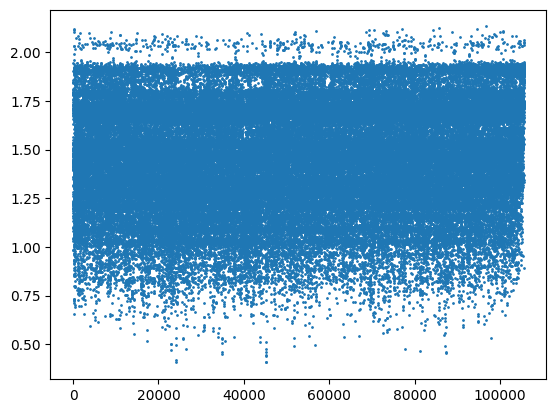

In [70]:
total_rows = 105554
batch_size = 512
prob_ls = np.zeros(df.shape[0])
count_p = 0
import matplotlib.pyplot as plt
for batch_start in range(0, total_rows, batch_size):
      batch_end = min(batch_start + batch_size, total_rows)
      str_ls = []
      for x in range(batch_start, batch_end):
          ls0 = []
          for col in col1:
            v = df.loc[x, col]
            v = str(v)
            ls0.append(v)
          str_ls.append(ls0)
      data_x = np.array(str_ls)
      print(f"Processing batch from row {batch_start} to {batch_end}: {data_x.shape}")

      x_train = []
      for row in str_ls:
          ls0 = []
          for item in row:
              ls0.append(dict.get(item, 0))
          x_train.append(ls0)

      x_train = torch.from_numpy(np.array(x_train))
      y_train = x_train[:, 1:]
      x_train = x_train[:, :-1]
      prob_distri = torch.softmax(tfm(x_train[:,:]),dim=-1)
      prob_distri.shape
      for k in range(1,len(col1)-2):
        prob_distri = torch.softmax(tfm(x_train[:,0:k]),dim=-1)
        for x in range(prob_distri.shape[0]):
            prob0 = 0
            prob0=prob_distri[x,k-1,y_train[x,k-1]].item()
            prob_ls[batch_start + x]+=prob0
        #print(k)
      print(count_p)
      count_p += 1
plt.scatter(range(len(prob_ls)),prob_ls,s=1)
        #get minum prob index to locate least likely combination across data

print(np.argmin(prob_ls))
        #df.loc[294]

In [72]:
sorted(prob_ls)[1999]

0.8669337563915178

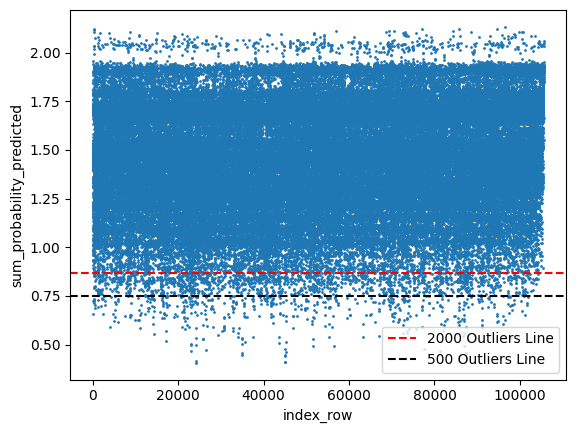

In [73]:
plt.scatter(range(len(prob_ls)),prob_ls,s=1)
plt.xlabel("index_row")
plt.ylabel("sum_probability_predicted")
plt.axhline(y=0.866, color='r', linestyle='--', label='2000 Outliers Line')
plt.axhline(y=0.75, color='black', linestyle='--', label='500 Outliers Line')
plt.legend()
plt.show()

Transformer end

In [74]:
df["transformer_outlier"] = prob_ls
df.to_csv("transformer_predict.csv")

In [80]:
df_1 = df[['index', 'Date_start_contract', 'Date_last_renewal',
       'Date_next_renewal', 'Date_birth', 'Date_driving_licence',
       'Distribution_channel', 'Seniority', 'Policies_in_force',
       'Max_policies', 'Max_products', 'Lapse', 'Date_lapse', 'Payment',
       'Premium', 'Cost_claims_year', 'N_claims_year', 'N_claims_history',
       'R_Claims_history', 'Type_risk', 'Area', 'Second_driver',
       'Year_matriculation', 'Power', 'Cylinder_capacity', 'Value_vehicle',
       'N_doors', 'Type_fuel', 'Length', 'Weight',
        'Age_at_contract_start',
       'Driving_experience_at_contract_start', 'Contract_duration',
       'Days_until_next_renewal', 'Total_contract_duration',
       'Contract_terminated']]
#df_p2 = process_data(df)

In [139]:
sorted(new)[307]

0.7146821170608746

In [156]:
dataframe["new"] = prob_ls
dataframe

,Date_start_contract,Date_last_renewal,Date_next_renewal,Date_birth,Date_driving_licence,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,...,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight,new
0,05/11/2015,05/11/2015,05/11/2016,15/04/1956,20/03/1976,0,4,1,2,1,...,0,2004,80,599,7068.00,0,P,NaN,190,1.632501
1,05/11/2015,05/11/2016,05/11/2017,15/04/1956,20/03/1976,0,4,1,2,1,...,0,2004,80,599,7068.00,0,P,NaN,190,1.659691
2,05/11/2015,05/11/2017,05/11/2018,15/04/1956,20/03/1976,0,4,2,2,1,...,0,2004,80,599,7068.00,0,P,NaN,190,1.438368
3,05/11/2015,05/11/2018,05/11/2019,15/04/1956,20/03/1976,0,4,2,2,1,...,0,2004,80,599,7068.00,0,P,NaN,190,1.459771
4,26/09/2017,26/09/2017,26/09/2018,15/04/1956,20/03/1976,0,4,2,2,1,...,0,2004,80,599,7068.00,0,P,NaN,190,1.474777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,30/07/2018,30/07/2018,30/07/2019,25/07/1981,14/02/2007,0,1,1,1,1,...,0,2000,110,1997,24320.00,5,D,4.740,1480,1.923650
105551,16/08/2018,16/08/2018,16/08/2019,08/12/1976,29/11/2017,0,1,1,1,1,...,0,2013,129,1998,30861.97,5,P,4.650,1440,1.908169
105552,21/11/2018,21/11/2018,21/11/2019,01/04/1974,05/10/2011,0,1,1,1,1,...,0,1999,55,999,7800.00,5,P,3.495,830,1.898992
105553,21/11/2018,21/11/2018,21/11/2019,15/09/1946,02/02/1982,0,1,1,1,1,...,0,2004,90,1753,16610.00,5,D,4.555,1399,1.863445


In [130]:
Index(['Distribution_channel', 'Seniority', 'Policies_in_force',
       'Max_policies', 'Max_products', 'Lapse', 'Payment', 'Premium',
       'Cost_claims_year', 'N_claims_year', 'N_claims_history',
       'R_Claims_history', 'Area', 'Second_driver', 'Year_matriculation',
       'Power', 'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Length',
       'Weight', 'new', 'Age_at_contract_start',
       'Driving_experience_at_contract_start', 'Contract_duration',
       'Days_until_next_renewal', 'Total_contract_duration',
       'Contract_terminated', 'Type_risk_1', 'Type_risk_2', 'Type_risk_3',
       'Type_risk_4', 'Type_fuel_D', 'Type_fuel_P'],
      dtype='object')

(102138, 33)

In [159]:
df_p.columns

Index(['Distribution_channel', 'Seniority', 'Policies_in_force',
       'Max_policies', 'Max_products', 'Lapse', 'Payment', 'Premium',
       'Cost_claims_year', 'N_claims_year', 'N_claims_history',
       'R_Claims_history', 'Area', 'Second_driver', 'Year_matriculation',
       'Power', 'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Length',
       'Weight', 'new', 'Age_at_contract_start',
       'Driving_experience_at_contract_start', 'Contract_duration',
       'Days_until_next_renewal', 'Total_contract_duration',
       'Contract_terminated', 'Type_risk_1', 'Type_risk_2', 'Type_risk_3',
       'Type_risk_4', 'Type_fuel_D', 'Type_fuel_P'],
      dtype='object')

In [161]:
dataframe["new"] = prob_ls
df_p = process_data(dataframe)
new = df_p["new"]
df_p.drop(columns="new")
df_p= df_p[['Distribution_channel',
       'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
       'Lapse', 'Payment', 'Premium', 'Cost_claims_year',
       'N_claims_year', 'N_claims_history', 'R_Claims_history', 
       'Area', 'Second_driver', 'Year_matriculation', 'Power',
       'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Length',
       'Weight','Type_risk_1', 'Type_risk_2', 'Type_risk_3',
       'Type_risk_4', 'Type_fuel_D', 'Type_fuel_P']]

In [151]:
dataframe.drop(col)

,Distribution_channel,Seniority,Policies_in_force,Max_policies,Max_products,Lapse,Date_lapse,Payment,Premium,Cost_claims_year,...,Area,Second_driver,Year_matriculation,Power,Cylinder_capacity,Value_vehicle,N_doors,Type_fuel,Length,Weight
0,0,4,1,2,1,0,NaT,0,222.52,0.0,...,0,0,2004,80,599,7068.00,0,P,NaN,190
1,0,4,1,2,1,0,NaT,0,213.78,0.0,...,0,0,2004,80,599,7068.00,0,P,NaN,190
2,0,4,2,2,1,0,NaT,0,214.84,0.0,...,0,0,2004,80,599,7068.00,0,P,NaN,190
3,0,4,2,2,1,0,NaT,0,216.99,0.0,...,0,0,2004,80,599,7068.00,0,P,NaN,190
4,0,4,2,2,1,0,NaT,1,213.70,0.0,...,0,0,2004,80,599,7068.00,0,P,NaN,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105550,0,1,1,1,1,0,NaT,0,263.79,0.0,...,0,0,2000,110,1997,24320.00,5,D,4.740,1480
105551,0,1,1,1,1,0,NaT,0,418.97,0.0,...,0,0,2013,129,1998,30861.97,5,P,4.650,1440
105552,0,1,1,1,1,0,NaT,1,571.91,0.0,...,0,0,1999,55,999,7800.00,5,P,3.495,830
105553,0,1,1,1,1,0,NaT,0,339.66,0.0,...,0,0,2004,90,1753,16610.00,5,D,4.555,1399


In [157]:
def process_data(dataframe: pd.DataFrame) -> pd.DataFrame:
    dataframe = process_date_columns(dataframe)
    dataframe = process_categorical_columns(dataframe)
    dataframe = process_numerical_columns(dataframe)
    dataframe = process_binary_columns(dataframe)
    return dataframe


In [166]:
sorted(prob_ls)[26389]

1.2568533255252987

[1 1 1 ... 1 1 1]


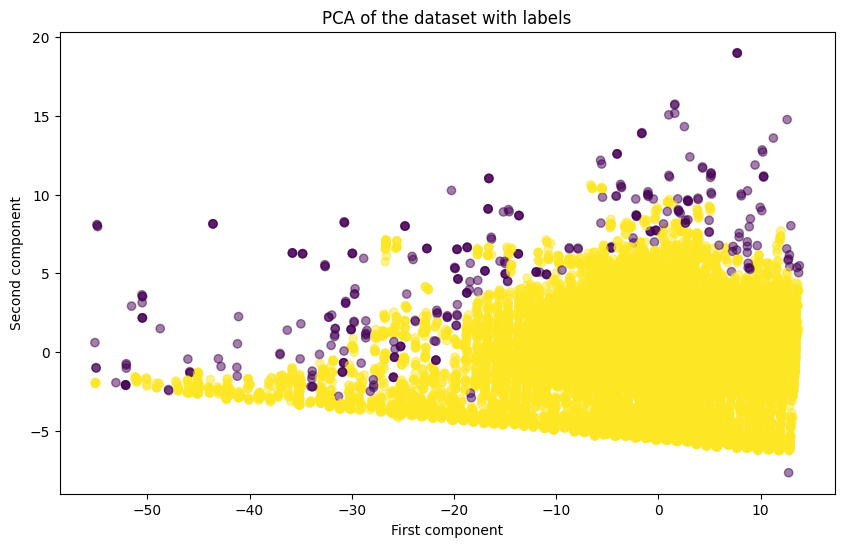

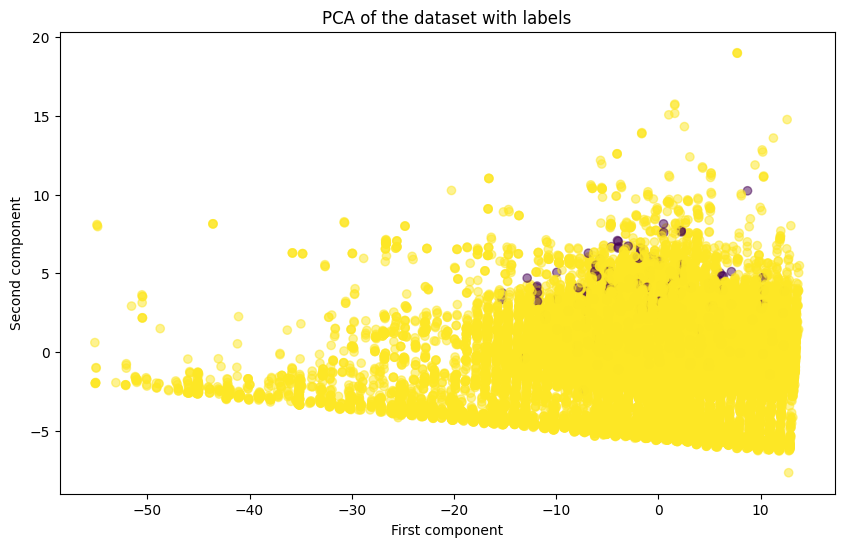

In [165]:
from sklearn.cluster import DBSCAN
#df_p = process_data(dataframe)
dataframe["new"] = prob_ls
df_p = process_data(dataframe)
new = df_p["new"]
df_p.drop(columns="new")
df_p= df_p[['Distribution_channel',
       'Seniority', 'Policies_in_force', 'Max_policies', 'Max_products',
       'Lapse', 'Payment', 'Premium', 'Cost_claims_year',
       'N_claims_year', 'N_claims_history', 'R_Claims_history', 
       'Area', 'Second_driver', 'Year_matriculation', 'Power',
       'Cylinder_capacity', 'Value_vehicle', 'N_doors', 'Length',
       'Weight','Type_risk_1', 'Type_risk_2', 'Type_risk_3',
       'Type_risk_4', 'Type_fuel_D', 'Type_fuel_P']]

def get_labels_dbscan(dataframe: pd.DataFrame) -> pd.DataFrame:
    """
    0: anomaly
    1: normal
    """
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(dataframe)

    clf = DBSCAN(eps=0.5, min_samples=5)
    labels = clf.fit_predict(pca_result)
    labels = (labels != -1).astype(int)
    return labels

train_labels_dbscan = get_labels_dbscan(df_p)
print(train_labels_dbscan)
#test_labels_dbscan = get_labels_dbscan(df_test)
is_outlier = []
for x in new:
    if x<0.7146:
        is_outlier.append(0)
    else:
        is_outlier.append(1)

draw_pca(df_p, train_labels_dbscan, title="PCA of the dataset with labels")
draw_pca(df_p, is_outlier, title="PCA of the dataset with labels")

In [88]:
k = 0
for x in train_labels_dbscan:
    if x ==0:
        k+=1
print(k)

308
